In [6]:
import numpy as np
from scipy.stats import levy_stable, uniform, multivariate_normal
from scipy.interpolate import interp1d

def prior_sample():
    # Sample from prior distribution
    # For univariate alpha-stable models, sample each parameter from its respective uniform distribution
    alpha = uniform.rvs(1.1, 0.9)  # U[1.1, 2]
    beta = uniform.rvs(-1, 2)  # U[-1, 1]
    gamma = uniform.rvs(0, 300)  # U[0, 300]
    delta = uniform.rvs(-300, 600)  # U[-300, 300]
    return alpha, beta, gamma, delta

def simulate_data(theta):
    # Simulate data from the model given parameters theta
    alpha, beta, gamma, delta = theta
    return levy_stable.rvs(alpha, beta, loc=gamma, scale=delta, size=200)

def compute_quantiles(data):
    # Compute quantile-based summary statistics
    quantiles = np.percentile(data, [5, 25, 50, 75, 95])
    v_alpha = (quantiles[4] - quantiles[0]) / (quantiles[3] - quantiles[1])
    v_beta = (quantiles[4] + quantiles[0] - 2 * quantiles[2]) / (quantiles[4] - quantiles[0])
    v_gamma = (quantiles[3] - quantiles[1]) / quantiles[2]
    return v_alpha, v_beta, v_gamma

def summary_statistics(data):
    # Compute summary statistics of the data
    # This function should return low-dimensional summary statistics S(data)
    # For univariate alpha-stable models, use quantile-based estimators along with the mean of the data
    v_alpha, v_beta, v_gamma = compute_quantiles(data)
    mean_x = np.mean(data)
    return v_alpha, v_beta, v_gamma, mean_x

def estimate_covariance(theta_hat):
    # Estimate covariance of summary statistics based on 1000 draws from the model
    samples = [simulate_data(theta_hat) for _ in range(1000)]
    summary_stats = np.array([summary_statistics(sample) for sample in samples])
    return np.cov(summary_stats, rowvar=False)

def smoothing_kernel(y, x, epsilon, covariance):
    # Define smoothing kernel using a Gaussian kernel with estimated covariance
    return multivariate_normal.pdf(y, mean=x, cov=epsilon**2 * covariance)

def mutation_kernel(theta_t, theta_prev, weights_prev):
    # Define mutation kernel based on the provided information
    # For univariate alpha-stable models, use a Gaussian kernel with mean theta_prev[i] and covariance Λ
    # Λ = diag(0.25, 0.25, 1, 1)
    covariance = np.diag([0.25, 0.25, 1, 1])
    new_theta = np.zeros_like(theta_t)
    print('new_theta : ', new_theta)
    """
    for i in range(len(weights_prev)):
        print(f'theta_prev[{i}] = {theta_prev[i]}')
        new_theta += weights_prev[i] * multivariate_normal(mean=theta_prev[i], cov=covariance).pdf(theta_t)
    """
    return new_theta
def M_t(theta, theta_prev, weights_prev) :
    covariance = np.diag([0.25, 0.25, 1, 1])
    return np.sum(weights_prev*multivariate_normal(mean=theta_prev, cov=covariance).pdf(theta))

def generate_samples_from_M(N, theta_prev, covariance, weights_prev):
    num_components = len(weights_prev)
    dim = len(theta_prev[0])
    samples = np.zeros((N, dim))
    
    for i in range(N):
        # Choose a component based on the weights
        component = np.random.choice(range(num_components), p=weights_prev)
        # Generate a sample from the chosen component
        sample = np.random.multivariate_normal(theta_prev[component], covariance)
        samples[i] = sample
        
    return samples  

def resample(weights):
    # Resampling step
    indexes = np.random.choice(range(len(weights)), size=len(weights), p=weights)
    return indexes

def compute_weights(theta, data, t, ct, epsilon):
    # Compute weights and rejection step
    lf_posterior = likelihood_free_posterior(theta, data, epsilon)
    mutation = mutation_kernel(theta)
    weight, corrected_weight = lf_posterior / mutation, 0 # Corrected weight initially set to 0
    rejection_prob = 1 - min(1, weight / ct)
    if np.random.rand() < rejection_prob:
        return None, None  # Reject sample
    else:
        return weight, weight / (1 - rejection_prob)

def likelihood_free_posterior(theta, data, epsilon):
    # Compute likelihood-free posterior using Monte Carlo estimate
    P = 1000  # Number of Monte Carlo samples
    samples = [simulate_data(theta) for _ in range(P)]
    summary_y = summary_statistics(data)
    """
    weights = [smoothing_kernel(summary_y, summary_statistics(x), epsilon) for x in samples]
    weights /= np.sum(weights)  # Normalize weights
    return np.mean(weights)
    """
    return np.sum([smoothing_kernel(summary_y, summary_statistics(x), epsilon) for x in samples])/P

def main():
    T = 10  # Number of iterations
    N = 1000  # Number of particles
    covariance = np.diag([0.25, 0.25, 1, 1])
    epsilons = np.linspace(0.1, 0.01, T)  # Tolerance schedule
    print('espsilons', epsilons)
    # Simulate observed data
    observed_data = levy_stable.rvs(1.7, 0.9, loc=10, scale=10, size=200)
    print('observed data y : \n',observed_data)
    # Initialize weights and particles
    weights = np.ones(N) / N
    print('weights:', weights)
    particles = [prior_sample() for _ in range(N)]
    print("particles : ",particles)
    theta = particles

    for t in range(T):
        print('t=',t)
        epsilon = epsilons[t]
        print("e_t = ", epsilon)
        # Resample particles
        #indexes = resample(weights)
        #print("indexes : ", indexes)
        theta_prev = theta
        
        # Mutation and correction step
        #sample theta from the mutation kernel density estimate
        #for i in range(N):
            #theta_prev = particles[indexes[i]]
        print("theta_prev :\n", theta_prev)
        theta = generate_samples_from_M(N,theta_prev=theta_prev,covariance=covariance,weights_prev = weights)
        print('theta :\n', theta)
        print('theta.shape = ',theta.shape )
        # set weights for theta :
        weights = 
        weight, corrected_weight = compute_weights(theta, observed_data, t, np.quantile(weights, 0.9), epsilon)
        print("weight = ",weight)
        if weight is not None:
            particles[i] = theta
            weights[i] = corrected_weight
        print("weights : ", weights)
        print("particles : ", particles)

    # Final weighted sample
    final_particles = [(weights[i], particles[i]) for i in range(N)]



In [7]:
main()

espsilons [0.1  0.09 0.08 0.07 0.06 0.05 0.04 0.03 0.02 0.01]
observed data y : 
 [-1.52518365e+00 -6.26030914e+00  2.94369560e+01  2.91267517e+01
  9.03902246e+00  2.61363479e+01 -1.09084149e+01 -2.02909876e+00
  6.11356893e-01  9.66693613e+00  1.28421390e+01  2.48060483e+01
  1.00616702e+00  2.78228697e+01  2.30345855e+01  1.75996577e+01
  3.57370563e+01  2.52430076e+01  2.01042113e+01  2.87460124e+00
  3.65847500e+00  1.72227164e+01 -1.99868896e+01  8.27089692e+00
  7.10695344e+00  2.81625136e+01 -1.58091684e+00 -9.46923741e-01
  5.69215566e+00 -9.76494157e+00  2.89891629e+00  6.98522611e+00
 -1.41283766e+01 -4.50831137e+00 -8.89101866e+00  1.69532677e+01
  1.04558822e+01  9.41036447e+00 -5.70226329e+00  1.23365705e+00
 -8.92327741e+00  3.16003027e+01  2.36777192e+01  2.35604658e+01
 -1.25980630e+01  1.79767711e+01  2.53212404e+01 -1.50521588e+01
  2.86613825e+01  3.32580005e+00 -2.98010716e+00  5.32694495e+01
  1.77094610e-01  5.39808002e+01  1.00763004e+01  2.75182985e+01
  5.0932

ValueError: too many values to unpack (expected 4)

In [5]:
import numpy as np

def generate_samples_from_M(N, theta_prev, covariance, weights_prev):
    num_components = len(weights_prev)
    dim = len(theta_prev[0])
    samples = np.zeros((N, dim))
    
    for i in range(N):
        # Choose a component based on the weights
        component = np.random.choice(range(num_components), p=weights_prev)
        # Generate a sample from the chosen component
        sample = np.random.multivariate_normal(theta_prev[component], covariance)
        samples[i] = sample
        
    return samples

# Example parameters
N = 1000
theta_prev = [np.array([1, 2, 3, 4]), np.array([5, 6, 7, 8])]
covariance = np.diag([0.25,0.25,1,1])
"""
covariance = [np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]),
                    np.array([[2, 0, 0, 0], [0, 2, 0, 0], [0, 0, 2, 0], [0, 0, 0, 2]])]
"""
weights_prev = [0.7, 0.3]

# Generate samples
samples = generate_samples_from_M(N, theta_prev, covariance, weights_prev)

# Print the first few samples
print(samples[:5])


[[0.20300776 2.07667669 4.32072187 2.25727713]
 [6.15098599 5.68052276 5.58214607 6.36695011]
 [1.45611163 1.07244888 3.00632458 4.40866576]
 [5.04172924 5.6884225  6.48725226 6.15897692]
 [1.19382038 1.7650686  2.80845403 3.59303308]]


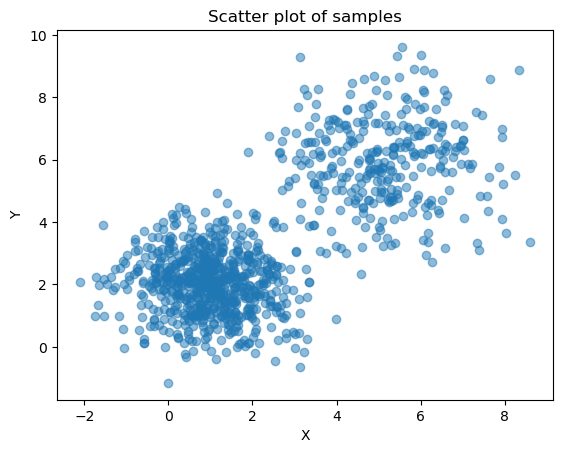

Sample mean:
[2.27924128 3.24891156 4.30060725 5.28328669]
Sample covariance matrix:
[[4.91306095 3.45346818 3.53997871 3.46740232]
 [3.45346818 4.62548598 3.25910385 3.27983049]
 [3.53997871 3.25910385 4.5908589  3.28913311]
 [3.46740232 3.27983049 3.28913311 4.47182654]]
Expected mean:
[2.2 3.2 4.2 5.2]
Expected covariance matrix:
[[1.3 0.  0.  0. ]
 [0.  1.3 0.  0. ]
 [0.  0.  1.3 0. ]
 [0.  0.  0.  1.3]]
Chi-squared statistic: [[[         nan          nan          nan          nan          nan
            nan          nan          nan          nan          nan]
  [         nan          nan          nan   8.                  nan
            nan          nan          nan          nan          nan]
  [         nan          nan   8.           8.                  nan
            nan          nan          nan          nan          nan]
  [         nan          nan          nan  13.66666667          nan
            nan          nan          nan          nan          nan]
  [         nan  

/opt/mamba/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7985: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs_float - f_exp)**2 / f_exp


AttributeError: 'multivariate_normal_frozen' object has no attribute 'ppf'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import chisquare
# Generate samples
samples = generate_samples(N, theta_prev, covariances_list, weights_prev)

# Visual Inspection
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter plot of samples')
plt.show()

# Check Moments
sample_mean = np.mean(samples, axis=0)
sample_cov = np.cov(samples, rowvar=False)
print("Sample mean:")
print(sample_mean)
print("Sample covariance matrix:")
print(sample_cov)

# Compare with expected mean and covariance
expected_mean = np.sum(np.array(theta_prev) * np.array(weights_prev)[:, np.newaxis], axis=0)
expected_cov = np.sum(np.array(covariances_list) * np.array(weights_prev)[:, np.newaxis, np.newaxis], axis=0)
print("Expected mean:")
print(expected_mean)
print("Expected covariance matrix:")
print(expected_cov)

# Goodness-of-Fit Test (Chi-squared test)
chi_squared, p_value = chisquare(np.histogramdd(samples, bins=10)[0])
print("Chi-squared statistic:", chi_squared)
print("p-value:", p_value)

# Quantile-Quantile (Q-Q) Plot
expected_distribution = multivariate_normal(mean=expected_mean, cov=expected_cov)
expected_quantiles = expected_distribution.ppf(np.linspace(0.01, 0.99, 100))
sample_quantiles = np.quantile(samples, np.linspace(0.01, 0.99, 100), axis=0)
plt.scatter(expected_quantiles, sample_quantiles)
plt.xlabel('Expected quantiles')
plt.ylabel('Sample quantiles')
plt.title('Q-Q Plot')
plt.plot([np.min(expected_quantiles), np.max(expected_quantiles)], [np.min(expected_quantiles), np.max(expected_quantiles)], color='red', linestyle='--')
plt.show()
